In this notebook, I perform exploratory data analysis to better understand the data. I then use machine learning techniques to predict price, using only the bottom 90% of the data (prices below $250).

In [1]:
#Basics
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from PIL import Image as im
from IPython.display import Image
from scipy import stats

#Wordcloud packages
from os import path
from PIL import Image
from IPython.display import SVG, display
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re 
import collections as c

#Modelling
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import joblib
import os




In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Data Cleaning 

In [3]:
#Importing data
ny_df = pd.read_csv('capstone_data/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
ny_df.head()
#ny_df.info()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [4]:
#Take a look at naan value percentages
missing_data_summary = (ny_df.isnull().sum()/len(ny_df))*100
missing_data_summary
#looks like if there are no reviews then last review and reviews per month are both NaN

id                                 0.000000
name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

In [5]:
#dropping rows with nan would mean losing 20% of our data, but dropping the columns would be a loss of a possibly important predictor
ny_df[ny_df.isna()["reviews_per_month"]]
reviews_per_month_no_nan=ny_df[ny_df.notnull()["reviews_per_month"]]
reviews_per_month_no_nan.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
5  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   
5        Chris           Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   
5  Entire home/apt    200               3                 74  2019-06-22   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
3               4.64                               1               194  
4               0.10                               1                 0  
5               0.59                               1               129

In [6]:
#Lets replace the nan values in the reviews_per_month with 0 and drop the last_review  column
ny_df["reviews_per_month"] = ny_df["reviews_per_month"].fillna(0)
ny_df.drop('last_review', axis=1, inplace=True)

In [7]:
#Now lets deal with the missing names and host names. Since we might want to use names later, we wont drop
#We also want to get rid of NaN values, so we'll replace NaN with Unkown 

ny_df["name"] = ny_df["name"].fillna("Unknown")
ny_df["host_name"] = ny_df["name"].fillna("Unknown")


In [8]:
#making sure we don't have any nan values left 
missing_data_summary = (ny_df.isnull().sum()/len(ny_df))*100
missing_data_summary

id                                0.0
name                              0.0
host_id                           0.0
host_name                         0.0
neighbourhood_group               0.0
neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
reviews_per_month                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

In [9]:
#Moving price to the end of the dataframe
ny_df.columns
ny_df=ny_df[['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365','price']]

In [10]:
#Take a look at the continuous data in our dataframe
display(ny_df.describe())

id       host_id      latitude     longitude  minimum_nights  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000    48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170        7.029962   
std    1.098311e+07  7.861097e+07      0.054530      0.046157       20.510550   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420        1.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070        1.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680        3.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275        5.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990     1250.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       48895.000000       48895.000000                    48895.000000   
mean           23.274466           1.090910                        7.143982   
std            44.550582           1.597283                       32.952519   
min             0.000000           0.000000                        1.000000   
25%             1.000000           0.040000                        1.000000   
50%             5.000000           0.370000                        1.000000   
75%            24.000000           1.580000                        2.000000   
max           629.000000          58.500000                      327.000000   

       availability_365         price  
count      48895.000000  48895.000000  
mean         112.781327    152.720687  
std          131.622289    240.154170  
min            0.000000      0.000000  
25%            0.000000     69.000000  
50%           45.000000    106.000000  
75%          227.000000    175.000000  
max          365.000000  10000.000000

When I get to modelling, the distribution of the target (price) will be important to the accuracy. Since the range of price looks high in the plot above, let's visualize what price looks like at different thresholds.  

The mean price is 152.7206871868289
The median price is 106.0
The max price is 10000


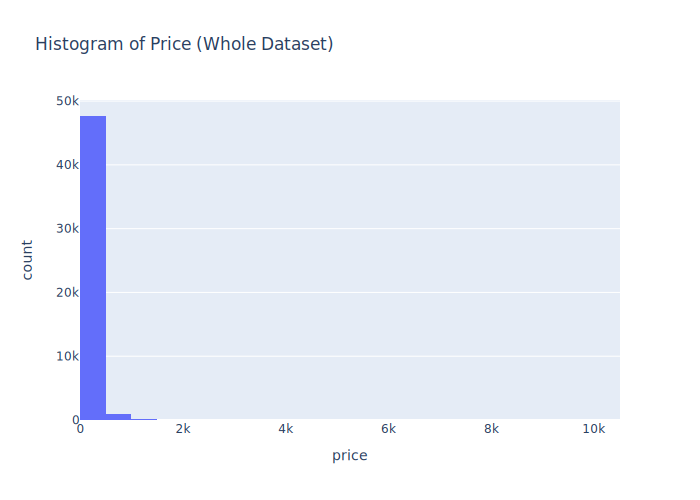

In [11]:

#Lets just take a look at our target, price, to see what kind of distribution it has
fig = px.histogram(ny_df, x="price", nbins=30, title='Histogram of Price (Whole Dataset)')

print(f'The mean price is {ny_df["price"].mean()}')
print(f'The median price is {ny_df["price"].median()}')
print(f'The max price is {ny_df["price"].max()}')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

The mean price is 140.23729859867893
The median price is 105.0
The max price is 999
Dropping 239 rows, 0.5 percent


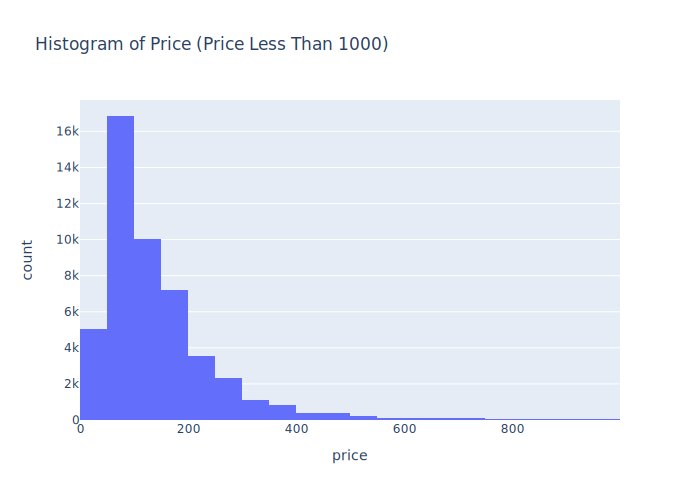

In [12]:
#Lets just take a look at our target, price, to see what kind of distribution it has
fig = px.histogram(ny_df[ny_df["price"]<1000], x="price", nbins=30, title='Histogram of Price (Price Less Than 1000)')

print(f'The mean price is {ny_df[ny_df["price"]<1000]["price"].mean()}')
print(f'The median price is {ny_df[ny_df["price"]<1000]["price"].median()}')
print(f'The max price is {ny_df[ny_df["price"]<1000]["price"].max()}')
print(f'Dropping {len(ny_df[ny_df["price"]>1000])} rows, {round((len(ny_df[ny_df["price"]>1000]))/len(ny_df), 3)*100} percent')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

The mean price is 107.89774777941831
The median price is 99.0
The max price is 249
Dropping 5208 rows, 10.7 percent


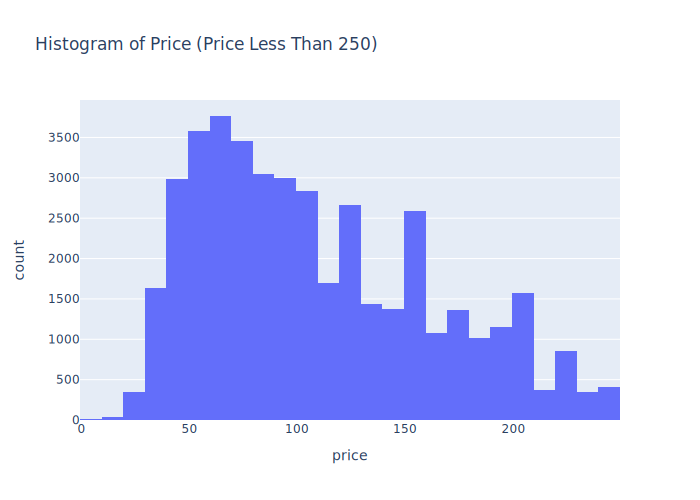

In [13]:
#Lets just take a look at our target, price, to see what kind of distribution it has
fig = px.histogram(ny_df[ny_df["price"]<250], x="price", nbins=30, title='Histogram of Price (Price Less Than 250)')

print(f'The mean price is {ny_df[ny_df["price"]<250]["price"].mean()}')
print(f'The median price is {ny_df[ny_df["price"]<250]["price"].median()}')
print(f'The max price is {ny_df[ny_df["price"]<250]["price"].max()}')
print(f'Dropping {len(ny_df[ny_df["price"]>250])} rows, {round((len(ny_df[ny_df["price"]>250]))/len(ny_df), 3)*100} percent')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

For this notebook, lets focus on prices that are below 250 dollars. The data is a lot less skewed for lower prices, and prices above 250 dollars only make up 10% of the data. 

In [14]:
#Dropping rows with price above $250
ny_df=ny_df[ny_df["price"]<250]

#Resetting index after dropping prices above $250
ny_df=ny_df.reset_index()
ny_df.drop("index", inplace=True, axis=1)

## EDA##

In this section, I will visualize the features to better understand the relationships in the data.

In [15]:
#Lets just check some basic correllation properties
ny_df.corr().style.background_gradient(cmap='coolwarm')

### Name EDA

It might be useful to count vectorize the names later on in the analysis, so lets see if there is common verbiage used by hosts in their name/description.

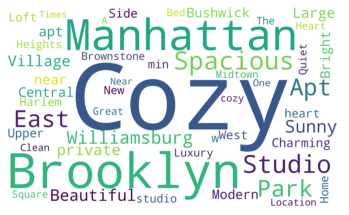

In [16]:
#Lets build a wordcloud of common words used in the "name" column

text = " ".join(name for name in ny_df.name)

whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')

names_concat = ''.join(filter(whitelist.__contains__, text))
names_concat=names_concat.split(" ")

#Creating dictionary of word counts
word_counts={}
for i in names_concat:
    if i not in word_counts:
        word_counts[i]=0
    word_counts[i]+=1

#Get rid of words with little meaning
stopwords = set(STOPWORDS)
stopwords.update(["Room", "Bedroom", "Private", "In", "in", "NYC", "apartment", "room", "bedroom", "br", "Apartment", "BR", " "])

#Get rid of stopwords in our dictionary
for i in stopwords:
    if i in word_counts:
        del word_counts[i]

#Use dictionary to build wordcloud 
wordcloud = WordCloud(background_color="white", width=5000, height=3000, max_words=50).generate_from_frequencies(word_counts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


One explanatory variable that would be helpful to our data would be number of bedrooms. Although we have a room type field, understanding the number of bedrooms might have more predictive power. Lets see if it's possible to strip out number of bedrooms from the name field.

In [17]:
#trying to see if we can get info on number of bedrooms from name

bedrooms=[]
for i in ny_df["name"]:
    m=re.match("^\d+\s(?i)(br|bedroom)", i)
    bedrooms.append(m)    

ny_df["number_of_bedrooms"]=bedrooms
ny_df["number_of_bedrooms"] = ny_df["number_of_bedrooms"].fillna("Unknown")
ny_df["number_of_bedrooms"] = ny_df["number_of_bedrooms"].astype('category')


ny_df.groupby("number_of_bedrooms")["price"].mean()




number_of_bedrooms
Unknown                                                    107.566487
<_sre.SRE_Match object; span=(0, 9), match='2 bedroom'>    105.000000
<_sre.SRE_Match object; span=(0, 9), match='1 Bedroom'>    130.000000
<_sre.SRE_Match object; span=(0, 9), match='1 Bedroom'>    195.000000
<_sre.SRE_Match object; span=(0, 9), match='1 Bedroom'>    230.000000
                                                              ...    
<_sre.SRE_Match object; span=(0, 9), match='2 Bedroom'>    195.000000
<_sre.SRE_Match object; span=(0, 9), match='3 Bedroom'>    110.000000
<_sre.SRE_Match object; span=(0, 4), match='3 Br'>         245.000000
<_sre.SRE_Match object; span=(0, 9), match='2 bedroom'>     80.000000
<_sre.SRE_Match object; span=(0, 9), match='1 bedroom'>     80.000000
Name: price, Length: 639, dtype: float64

Looks like only 648 out of 40k have bedroom info. This is likely insufficient to do modelling with

In [18]:
#Dropping this column since it won't be useful
ny_df.drop(["number_of_bedrooms"], inplace=True, axis=1)

Lets check out the word counts for the top most popular words in the name column. 

In [19]:
#sorting words_count dict by values (word counts)

sorted_keys = sorted(word_counts, key=word_counts.get, reverse=True)
sorted_keys

sorted_list_wc=[]
for r in sorted_keys:
    sorted_list_wc.append((r, word_counts[r]))

sorted_list_wc[1:20]

[('Cozy', 3951),
 ('Brooklyn', 3577),
 ('Manhattan', 2765),
 ('Spacious', 2707),
 ('Studio', 2617),
 ('East', 2353),
 ('Apt', 2336),
 ('Park', 2284),
 ('Williamsburg', 2223),
 ('Sunny', 2210),
 ('Beautiful', 1818),
 ('private', 1642),
 ('Village', 1597),
 ('Large', 1460),
 ('apt', 1351),
 ('near', 1348),
 ('Central', 1251),
 ('Bushwick', 1240),
 ('Bright', 1239)]

### Room Type EDA

The room type column is split into private, entire home/apartment, and shared room. I'd expect that these would have different prices associated with them. However, the data set is missing square footage and number of bedrooms which would be other (perhaps more useful) ways to measure the size of the space

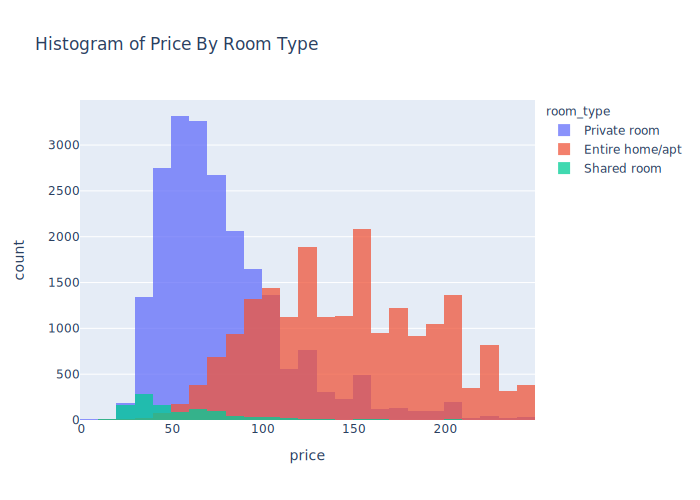

In [20]:
#Lets look at prices based on room type

fig = px.histogram(ny_df, x="price", color="room_type", nbins=30, title='Histogram of Price By Room Type')
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))


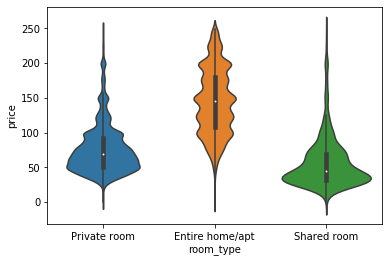

In [21]:
ax = sns.violinplot(x="room_type", y="price", data=ny_df)


It looks like these distributions are fairly different between private and shared room and entire apartment, indicating that room_type might be a good predictor of price.

### Minimum_nights EDA

Minimum_nights refers to the minimum number of nights that must be booked. It is not obvious how this will impact the per night price; however, longer stays might have a lower per night cost due to economies of scale. 

First, lets look at the distrbution of minimum nights in the data.

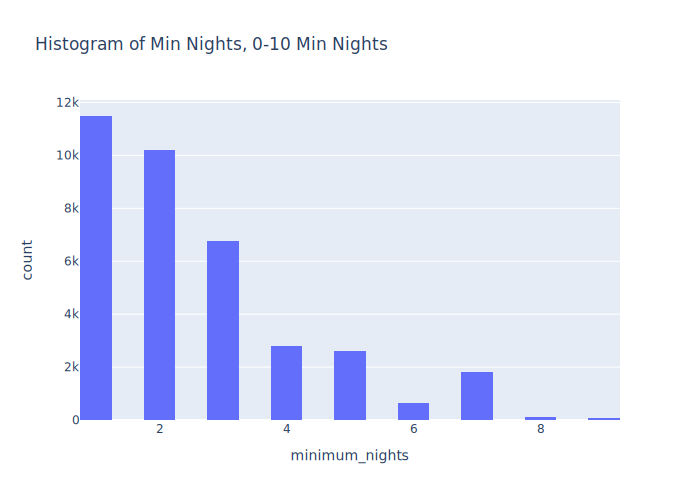

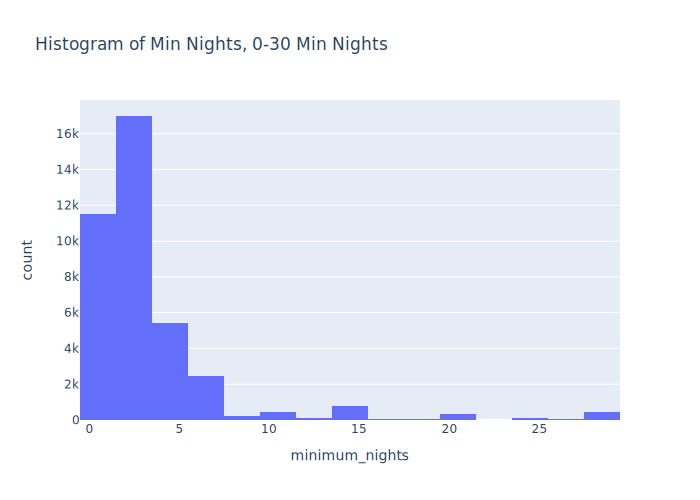

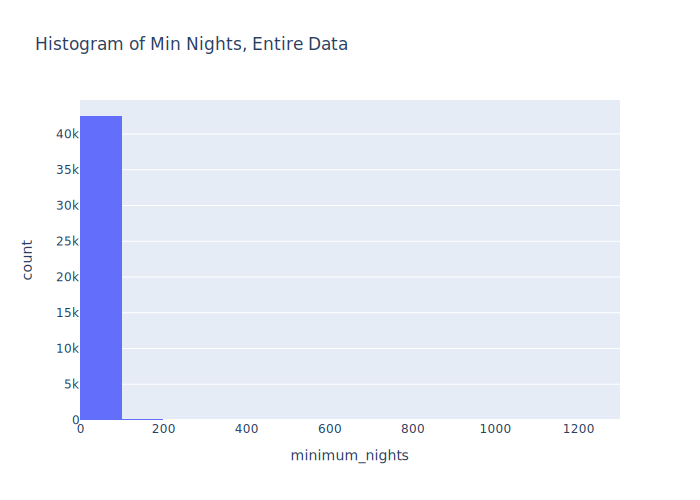

the mode is  0    1
dtype: int64
the median is  2.0
the mean is  6.856359417844336


In [22]:
fig = px.histogram(ny_df[ny_df["minimum_nights"]<10], x="minimum_nights", nbins=20, title='Histogram of Min Nights, 0-10 Min Nights')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

fig = px.histogram(ny_df[ny_df["minimum_nights"]<30], x="minimum_nights", nbins=20, title='Histogram of Min Nights, 0-30 Min Nights')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

fig = px.histogram(ny_df, x="minimum_nights", nbins=20, title='Histogram of Min Nights, Entire Data')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

print('the mode is ', ny_df["minimum_nights"].mode())
print('the median is ', ny_df["minimum_nights"].median())
print('the mean is ', ny_df["minimum_nights"].mean())








This column is highly skewed, with a few properties having minimum_nights set to over two years. The median is 2 nights and the vast majority are below a week. 

### Longitude/Latitude EDA 

Latitude and longitude describe the exact location of each Airbnb. Since Manhattan has lower longitudinal coordinates, I expect there will be a relationship there.

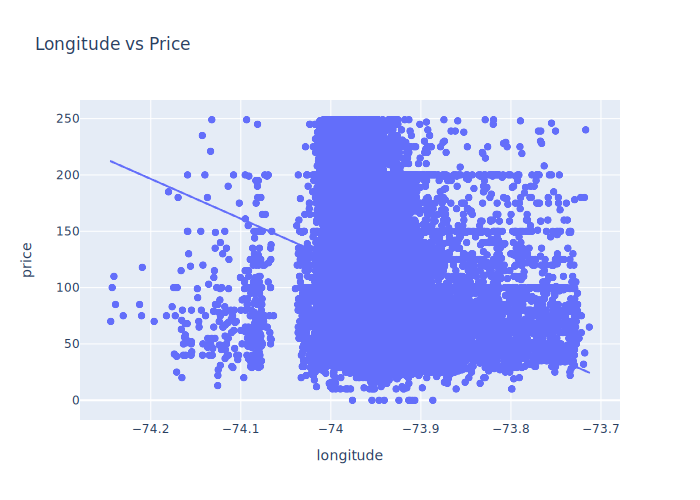

In [23]:
#Lets look at prices based on latitude (note that Mahattan has greater Longitude values than Brooklyn/Williamsburg)

fig = px.scatter(ny_df, x="longitude", y="price", title='Longitude vs Price', trendline='ols')
results = px.get_trendline_results(fig)
results = px.get_trendline_results(fig)
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

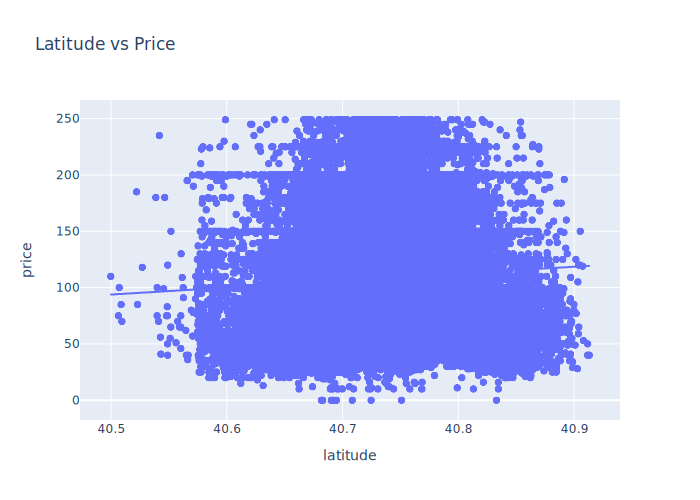

In [24]:
#Lets look at prices based on latitude (note that Mahattan has higher latitude values)

fig = px.scatter(ny_df[ny_df["price"]<1000], x="latitude", y="price", title='Latitude vs Price', trendline='ols')
results = px.get_trendline_results(fig)
results = px.get_trendline_results(fig)
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

It seems as though longitude has an inverse relationship with price and latitude has a postive relationship with price. This makes some sense as Manhattan has lower longitudinal coordinates and higher latitude coordinates. Longitude seems to be more predictive than latitude

### Neighborhood EDA

It would make sense that the different neighborhood groups would have different price distribitions. I would expect Manhattan to be the most expensive, and possibly Brooklyn as second most expensive.

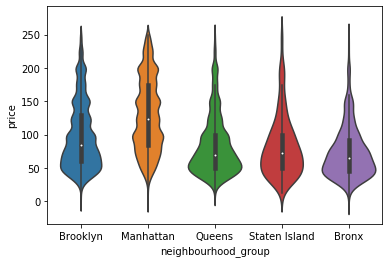

In [25]:
ax = sns.violinplot(x="neighbourhood_group", y="price", data=ny_df)

It looks like these neighbourhood groups do have different price distributions with Manhattan being the most expensive. This will probably be a highly predictive feature to use in the modelling.

### Room Type and Neighborhood Maps

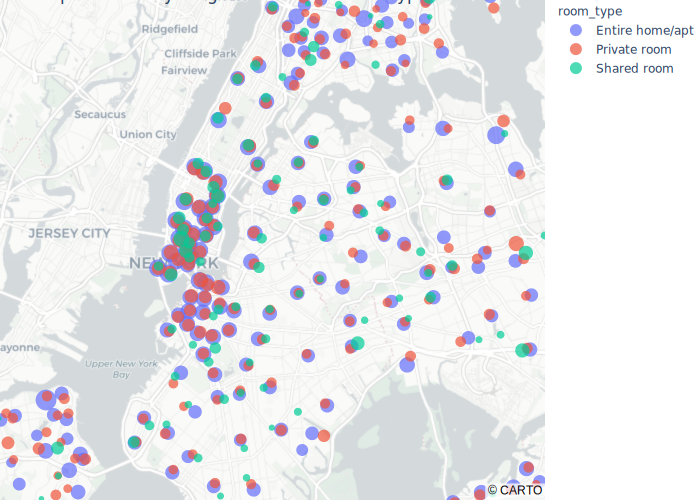

In [26]:
#Map looking at most expensive neighborhoods

neighborhoods=ny_df.groupby(["neighbourhood", "room_type"])[["price", "latitude", "longitude", "minimum_nights"]].mean().reset_index()
neighborhoods.sort_values('price', ascending=False, inplace=True)
rich_neighborhoods=neighborhoods


fig = px.scatter_mapbox(rich_neighborhoods, lat="latitude", lon="longitude",  size="price", color="room_type", size_max=15, zoom=10, hover_name="neighbourhood", hover_data=["price", "minimum_nights"], title="Map of Prices By Neighborhood and Roomtype")
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

It might be helpful to see which neighborhoods tend to have more expensive listings. Lets assign color to price.

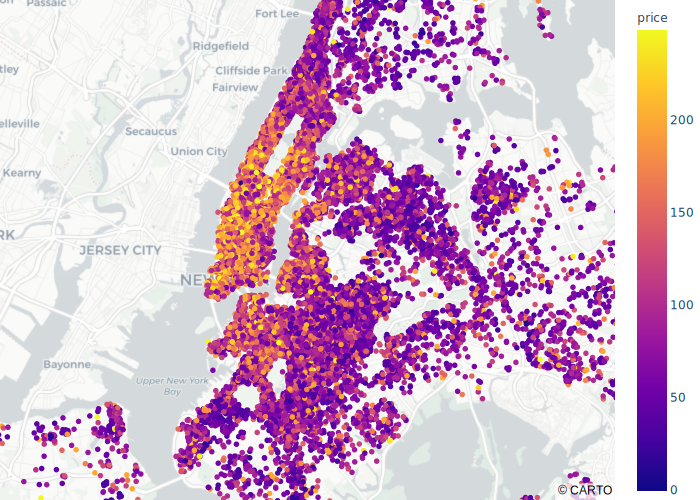

In [27]:
#Map looking at prices for each Airbnb 


fig = px.scatter_mapbox(ny_df, lat="latitude", lon="longitude",  color="price", size_max=15, zoom=10)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

To understand where the neighborhood group borders are, lets visualize them on a map. 

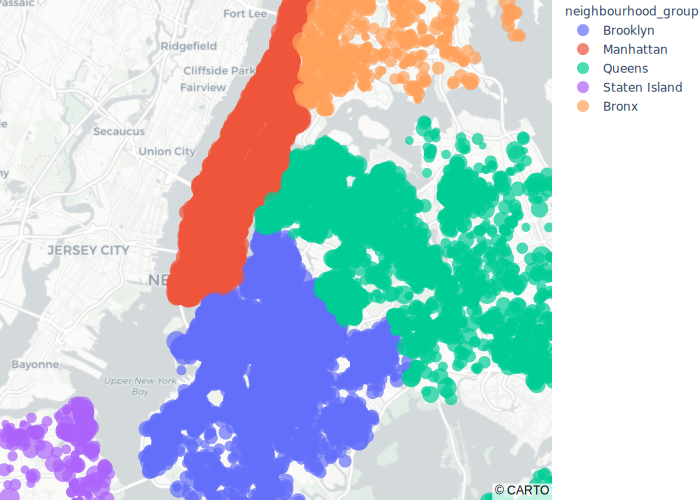

In [28]:
#Neighborhood Group Map
fig = px.scatter_mapbox(ny_df, lat="latitude", lon="longitude",  color="neighbourhood_group", size="price", size_max=15, zoom=10)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))


## Modeling 

The models run in this section include linear regression, lasso/ridge regression, decision tree regressor, random forest regressor, and a neural network. Again, this is modelling done on prices below $250 from the original data. 

In [29]:
#Checking the median and mean price
print(ny_df["price"].median())
print(ny_df["price"].mean())

99.0
107.89774777941831


### A Little More Preprocessing and Added Features

Lets one hot encode room_type, neighborhood_group, and neighborhood. I'll also add a new feature for distance from midtown, since the EDA suggested that a lot of more expensive properties are near Midtown. Note, name is still in the dataframe-- I'll address this later on. 

In [30]:
#adding dummies for roomtype
room_type_dummies=pd.get_dummies(ny_df['room_type'], prefix='room_type', drop_first=False).reset_index()
room_type_dummies.drop("index", axis=1, inplace=True)
ny_df_added_features = pd.concat([room_type_dummies, ny_df], axis=1)

#adding dist_from_midtown feature. After doing EDA on prices and location, a lot of the higher prices appeared to be very close to midtown. Lets construct a feature for this.
ny_df_added_features["dist_from_midtown"]=abs(ny_df_added_features["latitude"]-40.7069)+abs(ny_df_added_features["latitude"]+74.0031)

#adding dummies for neighborhood group
ny_df_added_features = pd.concat([ny_df_added_features ,pd.get_dummies(ny_df_added_features['neighbourhood_group'], prefix='neighbourhood_group', drop_first=False)],axis=1)

#adding dummies for neighborhood
ny_df_added_features = pd.concat([ny_df_added_features ,pd.get_dummies(ny_df_added_features['neighbourhood'], prefix='neighbourhood', drop_first=True)],axis=1)



In [31]:
#Dropping the original columns we just one hot encoded
ny_df_added_features.drop(["neighbourhood_group", "neighbourhood", "room_type", "host_id", "host_name", "id"], axis=1, inplace=True)

In [32]:
ny_df_added_features.head()

room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                          0                       1                      0   
1                          1                       0                      0   
2                          0                       1                      0   
3                          1                       0                      0   
4                          1                       0                      0   

                                               name  latitude  longitude  \
0                Clean & quiet apt home by the park  40.64749  -73.97237   
1                             Skylit Midtown Castle  40.75362  -73.98377   
2               THE VILLAGE OF HARLEM....NEW YORK !  40.80902  -73.94190   
3                   Cozy Entire Floor of Brownstone  40.68514  -73.95976   
4  Entire Apt: Spacious Studio/Loft by central park  40.79851  -73.94399   

   minimum_nights  number_of_reviews  reviews_per_month  \
0               1                  9               0.21   
1               1                 45               0.38   
2               3                  0               0.00   
3               1                270               4.64   
4              10                  9               0.10   

   calculated_host_listings_count  ...  neighbourhood_Westchester Square  \
0                               6  ...                                 0   
1                               2  ...                                 0   
2                               1  ...                                 0   
3                               1  ...                                 0   
4                               1  ...                                 0   

   neighbourhood_Westerleigh  neighbourhood_Whitestone  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

   neighbourhood_Williamsbridge  neighbourhood_Williamsburg  \
0                             0                           0   
1                             0                           0   
2                             0                           0   
3                             0                           0   
4                             0                           0   

   neighbourhood_Willowbrook  neighbourhood_Windsor Terrace  \
0                          0                              0   
1                          0                              0   
2                          0                              0   
3                          0                              0   
4                          0                              0   

   neighbourhood_Woodhaven  neighbourhood_Woodlawn  neighbourhood_Woodside  
0                        0                       0                       0  
1                        0                       0                       0  
2                        0                       0                       0  
3                        0                       0                       0  
4                        0                       0                       0  

[5 rows x 236 columns]

In [33]:
#Splitting data into remainder (train and validation) and test split of 20% (calling X datarame "no words" because I haven't count vectorized the name column yet).

#I want all the columns except price in my X dataframe
X=ny_df_added_features.loc[:, ny_df_added_features.columns != 'price']

#Price is the target
y=ny_df_added_features["price"]
split = 0.2
X_remainder_no_words, X_test_no_words, y_remainder, y_test = train_test_split(X, y, test_size=split, random_state=6)
for i in [X_remainder_no_words, X_test_no_words, y_remainder, y_test]:
    print(i.shape)



(34135, 235)
(8534, 235)
(34135,)
(8534,)


In [34]:
#Resettig axis and dropping index columns
X_remainder_no_words=X_remainder_no_words.reset_index()
X_remainder_no_words.drop("index", axis=1, inplace=True)

y_remainder=y_remainder.reset_index()
y_remainder.drop("index", axis=1, inplace=True)


X_test_no_words=X_test_no_words.reset_index()
X_test_no_words.drop("index", axis=1, inplace=True)

y_test=y_test.reset_index()
y_test.drop("index", axis=1, inplace=True)

Now that most of the preprocessing is done, let's check a scaled linear regression to see which columns are having the most effect on price. Note I am not scaling one hot encoded columns, only the continuous ones.

In [35]:
#Scaling X data so we can compare the effect different coefficients are having

X_remainder_no_words_scaled=X_remainder_no_words.copy()
X_test_no_words_scaled=X_test_no_words.copy()


scalerx = StandardScaler()
scalerx.fit(X_remainder_no_words_scaled[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_remainder_no_words_scaled[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_remainder_no_words_scaled[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_test_no_words_scaled[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_test_no_words_scaled[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])




Based on outside research, common sense, and EDA, it seems like price would mainly be a function of the room_type and general neighborhood group. Lets see how much of the variation can be explained by only these factors. I use statsmodels here so that the pvalues can easily be seen along with the coefficient values.

Before running the regression, I want to figure out which feature I should drop. Including all categories will result in perfect multicollinearity, but I want to drop one of the features with the highest collinearity. It looks like Private room and entire home are almost perfectly correlated. I will drop entire home. 

In [36]:
X = X_remainder_no_words_scaled[["room_type_Private room", "room_type_Entire home/apt","room_type_Shared room",
"neighbourhood_group_Manhattan",
"neighbourhood_group_Queens",
"neighbourhood_group_Staten Island",
"neighbourhood_group_Bronx","neighbourhood_group_Brooklyn"]]
X.corr().style.background_gradient(cmap='coolwarm')

In [37]:
#Baseline linear regression using scaled data so we can evaluate coefficients (not including latitude/longitude/dist_from_midtown)
X = X_remainder_no_words_scaled[["room_type_Private room", "room_type_Shared room",
"neighbourhood_group_Manhattan",
"neighbourhood_group_Queens",
"neighbourhood_group_Staten Island","neighbourhood_group_Brooklyn"]]
y = y_remainder
X_withconstant = sm.add_constant(X)


# 1. Instantiate Model
myregression = sm.OLS(y,X_withconstant)

# 2. Fit Model (this returns a seperate object with the parameters)
myregression_results = myregression.fit()

# Looking at the summary
myregression_results.summary()
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     5184.
Date:                Thu, 25 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:47:41   Log-Likelihood:            -1.7331e+05
No. Observations:               34135   AIC:                         3.466e+05
Df Residuals:                   34128   BIC:                         3.467e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                               117.6071      1.371     85.789      0.000     114.920     120.294
room_type_Private room              -64.1328      0.430   -149.152      0.000     -64.976     -63.290
room_type_Shared room               -84.8349      1.311    -64.686      0.000     -87.405     -82.264
neighbourhood_group_Manhattan        41.2055      1.385     29.752      0.000      38.491      43.920
neighbourhood_group_Queens            8.4073      1.466      5.734      0.000       5.534      11.281
neighbourhood_group_Staten Island     1.6081      2.702      0.595      0.552      -3.687       6.903
neighbourhood_group_Brooklyn         16.7387      1.381     12.121      0.000      14.032      19.445
==============================================================================
Omnibus:                     2360.194   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3064.079
Skew:                           0.633   Prob(JB):                         0.00
Kurtosis:                       3.743   Cond. No.                         20.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It looks like our R2 on the train plus validation is 0.477 with only including these regressors. We can see that having a private or shared room pulls down the price, and being in Manhattan increases the price. Note that I have dropped two categories (entire home and the Bronx), since only dropping one category resulted in a near zero eigenvalue (indicating very high multicollinearity). 

In [38]:
print(X_remainder_no_words.shape)
print(X_test_no_words.shape)
print(y_remainder.shape)
print(y_test.shape)

(34135, 235)
(8534, 235)
(34135, 1)
(8534, 1)


The main method of model comparison will be RMSE, the "root mean squared error" of our predictions from the actual values in the test set. It will also be helpful to visualize the errors as a histogram. I will define a function that will calculate the RMSE for any model.

In [39]:
#feed in the X_test dataframe, y_test, and the model
def get_errors(X, y_test, model):
    
    #predict the models 
    y_pred=model.predict(X)
    
    #create a dataframe to store the predictions, actual values, and errors
    y_test_df=y_test.copy()
    
    #add predictions to the dataframe
    y_test_df["pred"]=y_pred
    
    #add the squared error of each prediction from the actual value to the dataframe
    y_test_df["error"]=(y_test_df["price"]-y_test_df["pred"])**(2)
    
    #add the absolute squared error to the dataframe
    y_test_df["abs_error"]=abs((y_test_df["price"]-y_test_df["pred"]))


    #take the square root of the sum of the squared error column of the dataframe to get RMSE
    print(f'RMSE={(((y_test_df["error"].sum()))/len(y_test_df))**(1/2)}')
    
    #Plot the absolute errors in a histogram
    fig=px.histogram(x=y_test_df['abs_error'], title="Abs Error", nbins=30)


    img_bytes = pio.to_image(fig, format="svg")
    display(SVG(img_bytes))

Now lets try a regression with all of the continuous data plus the room_type one hot encoded and neighbourhood group one hot encoded. This regression includes 14 features. 

In [40]:
#Try linear model using continuous data plust one hot encoded data for room_type and neighborhood_group


X_remainder_baseline=X_remainder_no_words[['room_type_Private room', 'room_type_Shared room', 'latitude', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'dist_from_midtown', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island']]
X_test_baseline=X_test_no_words[['room_type_Private room', 'room_type_Shared room', 'latitude', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'dist_from_midtown', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island']]


# 1. Instantiate the model
linear_regression_model = LinearRegression()

# 2. Fit the model
linear_regression_model.fit(X_remainder_baseline, y_remainder)

#The intercept
intercept = linear_regression_model.intercept_

#The coefficient, notice it returns an array with one spot for each feature
coefficient = linear_regression_model.coef_


model_prediction_train = linear_regression_model.predict(X_remainder_baseline)
model_prediction_test = linear_regression_model.predict(X_test_baseline)



# Evaluate the model on each set
print(f'The R2 score on the training set: {r2_score(y_remainder,model_prediction_train)}')
print(f'The R2 score on the testing set: {r2_score(y_test,model_prediction_test)}')

print(f'The RMSE score on the training set: {(mean_squared_error(y_remainder,model_prediction_train))**(1/2)}')
print(f'The RMSE score on the testing set: {(mean_squared_error(y_test,model_prediction_test))**(1/2)}')




The R2 score on the training set: 0.5292996337524933
The R2 score on the testing set: 0.5378989363586834
The RMSE score on the training set: 36.79317844494327
The RMSE score on the testing set: 37.0411823352542


We can see that the R2 has increased from 0.477 to o.529 on the training set, meaning that more of the variation can be explained with the added regressors. From now on, lets pay attention to the RMSE on the test set as the main metric of model accuracy. This model has an RMSE of 37.

Now lets add the neighbourhood one hot encoding to the linear regression. This will bring our feautes up to over 200 since there are many neighbourhoods. Lets see what happens with the RMSE with these added regressors.

In [41]:
X_remainder_added=X_remainder_no_words.loc[:, X_remainder_no_words.columns != 'name']
X_test_added=X_test_no_words.loc[:, X_test_no_words.columns != 'name']

# 1. Instantiate the model
linear_regression_model = LinearRegression()

# 2. Fit the model
linear_regression_model.fit(X_remainder_added, y_remainder)

#The intercept
intercept = linear_regression_model.intercept_

#The coefficient, notice it returns an array with one spot for each feature
coefficient = linear_regression_model.coef_


model_prediction_train = linear_regression_model.predict(X_remainder_added)
model_prediction_test = linear_regression_model.predict(X_test_added)



# Evaluate the model on each set
print(f'The R2 score on the training set: {r2_score(y_remainder,model_prediction_train)}')
print(f'The R2 score on the testing set: {r2_score(y_test,model_prediction_test)}')

print(f'The RMSE score on the training set: {(mean_squared_error(y_remainder,model_prediction_train))**(1/2)}')
print(f'The RMSE score on the testing set: {(mean_squared_error(y_test,model_prediction_test))**(1/2)}')


#looks like we are massively overfitting- negative R2 on test 

The R2 score on the training set: 0.5616500520693478
The R2 score on the testing set: 0.5634525050467996
The RMSE score on the training set: 35.50630818416446
The RMSE score on the testing set: 36.002454220766644


It looks like the neighborhood one hot encoding brought the RMSE from 37 to 36 on the test set- a slight improvement.

RMSE=36.002454220766644


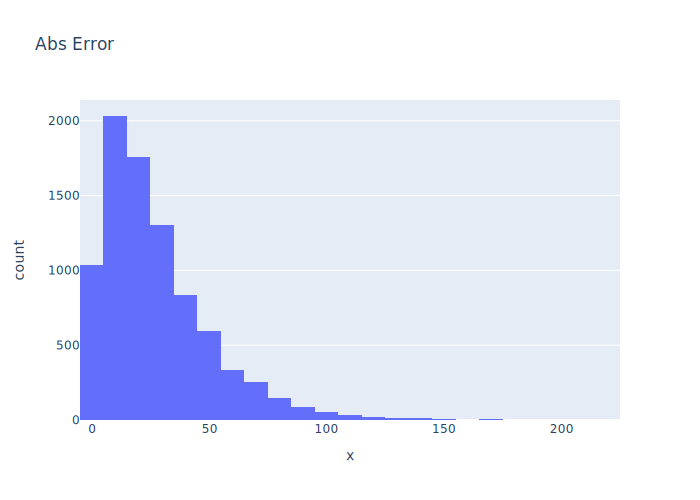

In [42]:
get_errors(X_test_added, y_test, linear_regression_model)

In [43]:
print(X_remainder_added.shape)
print(X_test_added.shape)
print(y_remainder.shape)
print(y_test.shape)





(34135, 234)
(8534, 234)
(34135, 1)
(8534, 1)


Now lets count vectorize the name column so the model can use this information. 

In [44]:
#Now looking at the count vectorized name data 


# 1. Instantiate, setting min_df to 10 which means that the minimum times the word must appear in the corpus is 10
bagofwords = CountVectorizer(min_df=10)

# 2. Fit 
bagofwords.fit(X_remainder_no_words["name"])

# 3. Transform 
X_remainder_bagofwords = bagofwords.transform(X_remainder_no_words["name"])
X_test_bagofwords = bagofwords.transform(X_test_no_words["name"])




In [45]:
#Adding the bag of words data to a dataframe from the array that the transform method produced
bagofwords.get_feature_names()
X_remainder_bagofwords.toarray()
X_test_bagofwords.toarray()


bag_of_words_train = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_remainder_bagofwords.toarray())
bag_of_words_test = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_test_bagofwords.toarray())




In [46]:
#Now we concat the count vectorized words to our X dataframes to get X_added_features
X_remainder_added_features=pd.concat([bag_of_words_train, X_remainder_no_words], axis=1)
X_test_added_features=pd.concat([bag_of_words_test, X_test_no_words], axis=1)

print(X_remainder_added_features.shape)
print(X_test_added_features.shape)



(34135, 1230)
(8534, 1230)


In [47]:
X_remainder_added_features.drop(["name"], axis=1, inplace=True)
X_test_added_features.drop(["name"], axis=1, inplace=True)

In [48]:
print(X_remainder_added_features.shape)
print(X_test_added_features.shape)

(34135, 1229)
(8534, 1229)


Coefficients:
Lasso: [-0. -0. -0. ... -0. -0. -0.]
Ridge: [[ -4.31933419  -3.62764816 -19.25073319 ... -13.56281734  -3.44215541
   -1.30468972]]

R-squared:
Lasso train: 0.48548529756151637
Ridge train: 0.6146046396372231
Lasso test: 0.4947969791370228
Ridge test: 0.6047666918227651
The RMSE score on the training set: 35.50630818416446
The RMSE score on the testing set: 36.002454220766644
Ridge Train and Test RMSE:
Ridge Train
RMSE=33.292643448028706


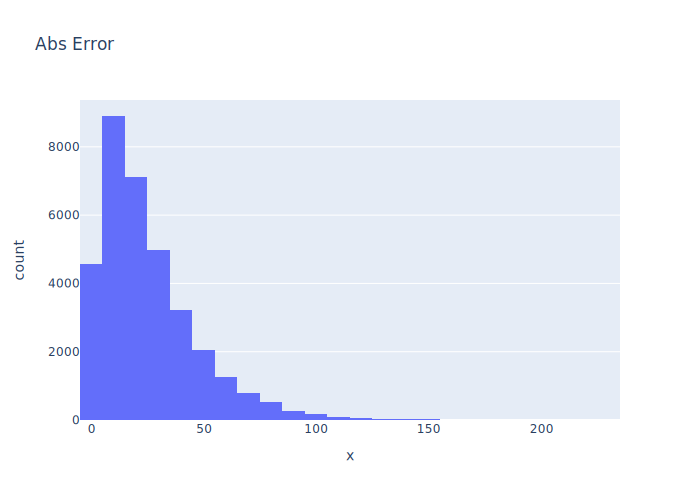

Ridge Test
RMSE=34.25651076687825


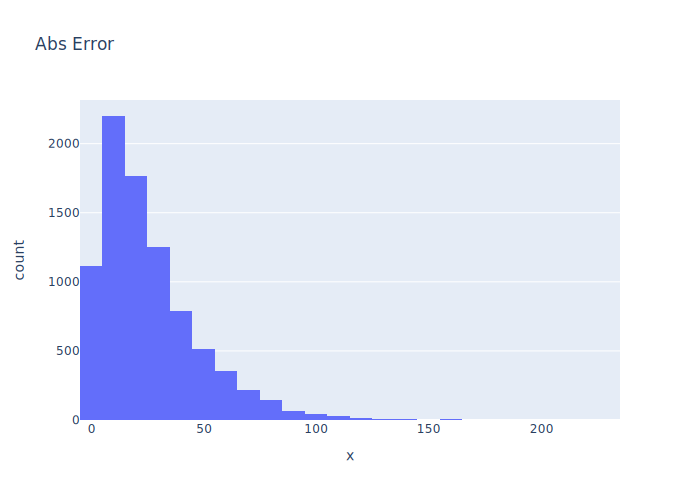

Lasso Train
RMSE=38.46749742139661


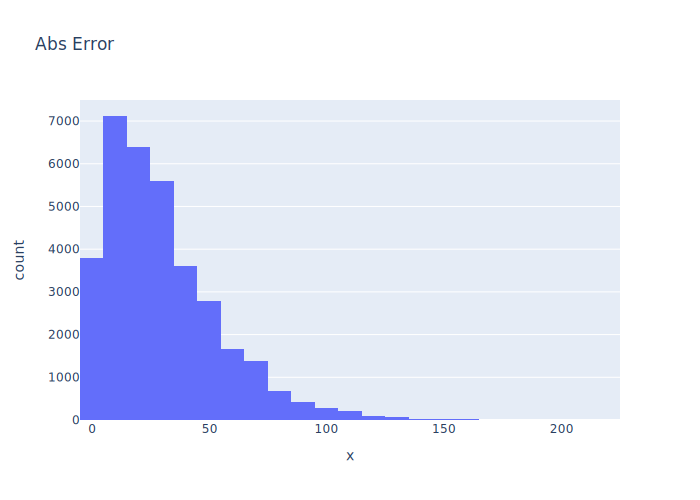

Lasso Test
RMSE=38.73016310879707


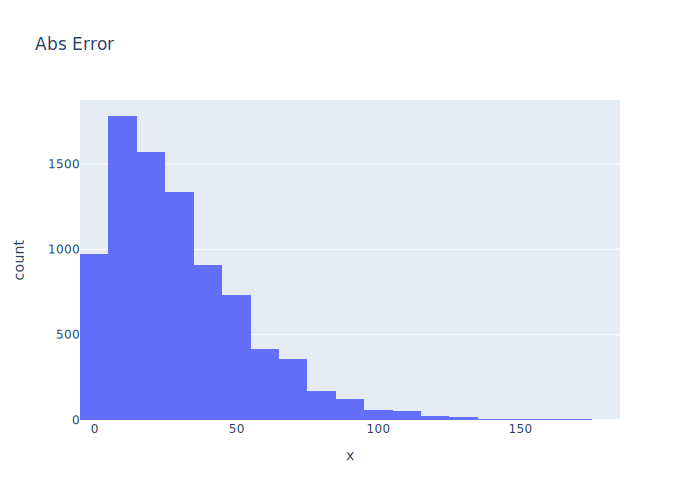

In [49]:


# Create the lasso and ridge models
lasso = Lasso()
lasso.fit(X_remainder_added_features,y_remainder)
ridge = Ridge(alpha=20)
ridge.fit(X_remainder_added_features,y_remainder)

print("Coefficients:")
print("Lasso:", lasso.coef_)
print("Ridge:", ridge.coef_)
print("")


# Compare R-squared
print("R-squared:")
print("Lasso train:", lasso.score(X_remainder_added_features,y_remainder))
print("Ridge train:", ridge.score(X_remainder_added_features,y_remainder))
print("Lasso test:", lasso.score(X_test_added_features,y_test))
print("Ridge test:", ridge.score(X_test_added_features,y_test))


print(f'The RMSE score on the training set: {(mean_squared_error(y_remainder,model_prediction_train))**(1/2)}')
print(f'The RMSE score on the testing set: {(mean_squared_error(y_test,model_prediction_test))**(1/2)}')

print("Ridge Train and Test RMSE:")

print("Ridge Train")
get_errors(X_remainder_added_features, y_remainder, ridge)

print("Ridge Test")
get_errors(X_test_added_features, y_test, ridge)


print("Lasso Train")
get_errors(X_remainder_added_features, y_remainder, lasso)

print("Lasso Test")
get_errors(X_test_added_features, y_test, lasso)

It would be interesting to see which words are most predictive of a higher prices and of a lower prices.

In [50]:
#Running a logistic regression of bag of words on price to see which words have the most predictive power

#Fit a logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(bag_of_words_train, y_remainder)

print(f'score on training: {logreg_model.score(X_remainder_bagofwords, y_remainder)}')
print(f'score on testing: {logreg_model.score(X_test_bagofwords, y_test)}')


bag_of_words_train.head()

score on training: 0.16912260143547678
score on testing: 0.07136161237403328


10  100  107  10min  10mins  116  12  14  15  15min  ...  yet  yoga  york  \
0   0    0    0      0       0    0   0   0   0      0  ...    0     0     0   
1   0    0    0      0       0    0   0   0   0      0  ...    0     0     0   
2   0    0    0      0       0    0   0   0   0      0  ...    0     0     0   
3   0    0    0      0       0    0   0   0   0      0  ...    0     0     0   
4   0    0    0      0       0    0   0   0   0      0  ...    0     0     0   

   yorker  you  young  your  yourself  zen  zoo  
0       0    0      0     0         0    0    0  
1       0    0      0     0         0    0    0  
2       0    0      0     0         0    0    0  
3       0    0      0     0         0    0    0  
4       0    0      0     0         0    0    0  

[5 rows x 995 columns]

In [51]:
indicies=[]
for i in bag_of_words_train:
    index=bag_of_words_train.columns.get_loc(i)
    indicies.append(index)

    
coef_lst=logreg_model.coef_.tolist()
tuples=list(zip(indicies, coef_lst[0]))
tuples

def Sort_Tuple(tup):  
  
    # reverse = None (Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1], reverse=True)  
    return tup 

Sorted_words=Sort_Tuple(tuples)

indicies_2=[]
for i in Sorted_words:
    indicies_2.append(i[0])

words_sorted=bag_of_words_train.columns[indicies_2]

#Bottom 30 words 
for i in words_sorted[0:20]:
    print(i)

nice
best
brownstone
view
with
coliving
hostel
find
can
ideal
contemporary
you
style
it
shared
master
all
living
the
comfortable


In [52]:
#redefine the sort function to sort in decending order  
def Sort_Tuple(tup):  
  
    # reverse = None (Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1])  
    return tup 

Reverse_Sorted_words=Sort_Tuple(tuples)

indicies_2=[]
for i in Reverse_Sorted_words:
    indicies_2.append(i[0])

words_sorted_reverse=bag_of_words_train.columns[indicies_2]

#Top 30 predictive words of high price
for i in words_sorted_reverse[0:30]:
    print(i)

private
cozy
apt
studio
manhattan
sunny
and
east
park
beautiful
nyc
in
near
village
bed
location
loft
large
home
bright
1br
one
new
charming
for
bushwick
luxury
from
central
quiet


Some of the words here make sense, and some of them are less logical. For example, in the bottom 30 words, "coliving" and "hostel" are suggestive of cheaper prices, but "space" doesn't necessarily imply cheap. 
Looking at words most predictive of high prices, "manhattan" makes sense, while "cozy" is less suggestive. Overall, it seems like the count vectorized name should provide some additional predictive power for the model. 

In [53]:
X_train_added_features, X_validation_added_features, y_train, y_validation = \
    train_test_split(X_remainder_added_features, y_remainder, test_size = 0.3,
                     random_state=1)

Lets try a decision tree regressor. I'll also use cross validation to select the correct max depth.

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

cross_validation_scores_val = []
cross_validation_scores_train = []




depths=range(1,10)
for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train_added_features, y_train)
    cv_score_val = np.mean(cross_val_score(tree, X_validation_added_features, y_validation, cv = 5))
    cross_validation_scores_val.append(cv_score_val)
    cv_score_train = np.mean(cross_val_score(tree, X_train_added_features, y_train, cv = 5))
    cross_validation_scores_train.append(cv_score_train)


    print(f'depth = {depth}')
    print(f"DT R^2 score on training set: {tree.score(X_train_added_features, y_train):0.3f}")
    print(f"DT R^2 score on validation set: {tree.score(X_validation_added_features, y_validation):0.3f}")
    


depth = 1
DT R^2 score on training set: 0.407
DT R^2 score on validation set: 0.410
depth = 2
DT R^2 score on training set: 0.468
DT R^2 score on validation set: 0.473
depth = 3
DT R^2 score on training set: 0.508
DT R^2 score on validation set: 0.513
depth = 4
DT R^2 score on training set: 0.535
DT R^2 score on validation set: 0.537
depth = 5
DT R^2 score on training set: 0.555
DT R^2 score on validation set: 0.554
depth = 6
DT R^2 score on training set: 0.574
DT R^2 score on validation set: 0.562
depth = 7
DT R^2 score on training set: 0.593
DT R^2 score on validation set: 0.566
depth = 8
DT R^2 score on training set: 0.613
DT R^2 score on validation set: 0.565
depth = 9
DT R^2 score on training set: 0.636
DT R^2 score on validation set: 0.566


Lets plot the validation and training scores and select the depeth with the highest validation.

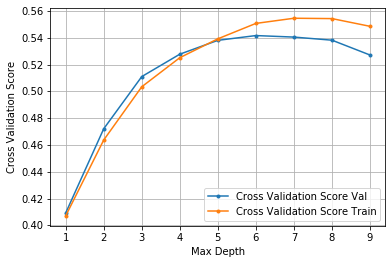

In [55]:
plt.figure()
plt.plot(depths, cross_validation_scores_val,label="Cross Validation Score Val",marker='.')
plt.plot(depths, cross_validation_scores_train,label="Cross Validation Score Train",marker='.')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

It looks like max depth of 8 performed the best on the cross validation scores. 

In [56]:
tree = DecisionTreeRegressor(max_depth=8)
tree.fit(X_train_added_features, y_train)
print(f'Validation score with optimal max depth of 8: {tree.score(X_validation_added_features, y_validation)}')
print(f'Test score with optimal max depth of 8: {tree.score(X_test_added_features, y_test)}')

Validation score with optimal max depth of 8: 0.5670841952018819
Test score with optimal max depth of 8: 0.5797486126039315


RMSE=35.32408609057897


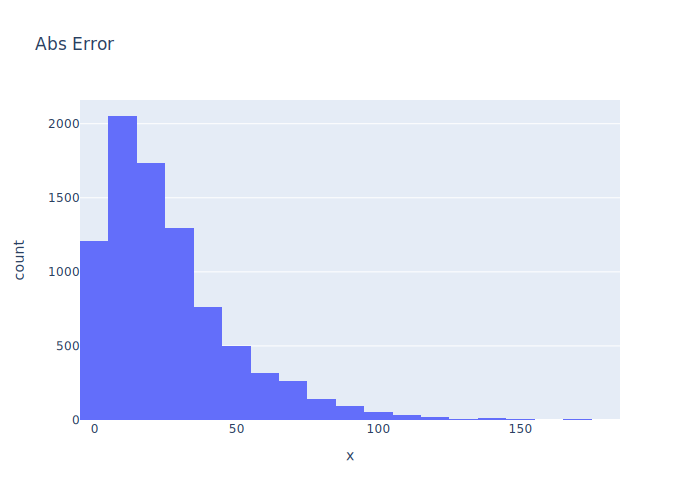

In [57]:
get_errors(X_test_added_features, y_test, tree)

In [58]:
cross_validation_scores_val = []
cross_validation_scores_train = []

max_depth_lst=range(1,10)
for max_depth in max_depth_lst:
    my_random_forest = RandomForestRegressor(n_estimators=100, max_depth=max_depth)
    my_random_forest.fit(X_train_added_features, y_train.values.ravel())
    cv_score_val = np.mean(cross_val_score(tree, X_validation_added_features, y_validation, cv = 5))
    cross_validation_scores_val.append(cv_score_val)
    cv_score_train = np.mean(cross_val_score(tree, X_train_added_features, y_train, cv = 5))
    cross_validation_scores_train.append(cv_score_train)
    

    print(f'depth = {max_depth}')
    print(f"DT R^2 score on training set: {my_random_forest.score(X_train_added_features, y_train):0.3f}")
    print(f"DT R^2 score on validation set: {my_random_forest.score(X_validation_added_features, y_validation):0.3f}")
    


depth = 1
DT R^2 score on training set: 0.407
DT R^2 score on validation set: 0.410
depth = 2
DT R^2 score on training set: 0.479
DT R^2 score on validation set: 0.483
depth = 3
DT R^2 score on training set: 0.524
DT R^2 score on validation set: 0.528
depth = 4
DT R^2 score on training set: 0.550
DT R^2 score on validation set: 0.551
depth = 5
DT R^2 score on training set: 0.572
DT R^2 score on validation set: 0.568
depth = 6
DT R^2 score on training set: 0.593
DT R^2 score on validation set: 0.581
depth = 7
DT R^2 score on training set: 0.615
DT R^2 score on validation set: 0.591
depth = 8
DT R^2 score on training set: 0.637
DT R^2 score on validation set: 0.598
depth = 9
DT R^2 score on training set: 0.660
DT R^2 score on validation set: 0.604


In [59]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'max_features': [1,2,3,4,5],
    'min_samples_leaf': [1,2,3,4,5],
    'min_samples_split': [1,2,3,4,5,6,7,8,9,10],
    'n_estimators': [10,20,30,100,200]
}

my_random_forest = RandomForestRegressor()

clf = GridSearchCV(my_random_forest, param_grid)

my_random_forest.fit(X_remainder_added_features, y_remainder.values.ravel())


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [60]:
my_random_forest.score(X_test_added_features, y_test)

0.6412054227893943

RMSE=32.63918394655382


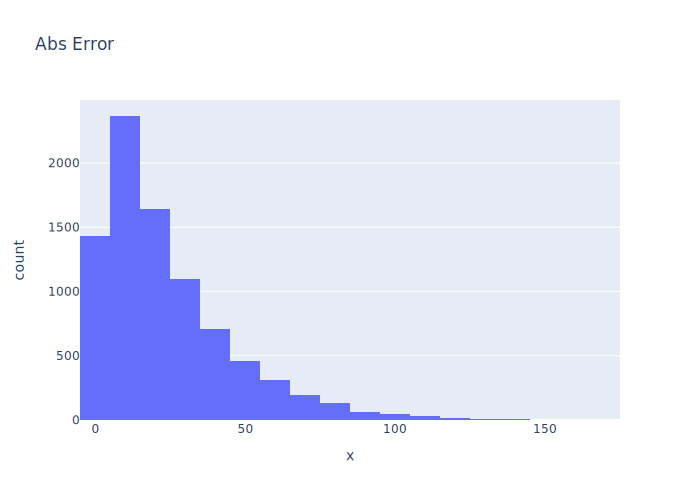

In [61]:
get_errors(X_test_added_features, y_test, my_random_forest)

In [62]:
param_grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'max_features': [180],
    'min_samples_leaf': [1,2,3,4,5],
    'min_samples_split': [1,2,3,4,5,6,7,8,9,10],
    'n_estimators': [10,20,30,100,200],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1]
}

gb_model = GradientBoostingRegressor()

clf = GridSearchCV(gb_model, param_grid)

gb_model.fit(X_remainder_added_features, y_remainder.values.ravel())

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [63]:
gb_model.score(X_test_added_features, y_test)

0.6176518737243242

RMSE=33.693477728633205


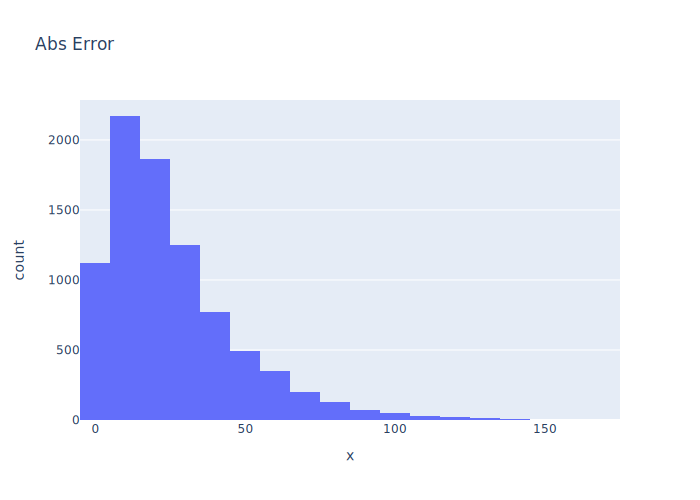

In [64]:
get_errors(X_test_added_features, y_test, gb_model)

In [65]:
#Scaling data for KNN (only scaling continuous data and not the one hot encoded data)

In [66]:
from sklearn.preprocessing import StandardScaler

scalerx = StandardScaler()
scalerx.fit(X_train_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_train_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_train_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_validation_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_validation_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_test_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_test_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_remainder_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_remainder_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])



Next, lets try a KNN Regressor. (warning: the cell below takes a very long time to run )

In [67]:
# Check if the model results file already exists
if os.path.exists('models/knn_regressor.pkl'):
    results = joblib.load('models/knn_regressor.pkl')

    print("We already ran the model once! Here are the results:")
    print(f"RMSE: {results['RMSE']}")
    print(f"best params: {results['best_params']}")

# If it doesn't exist, run our model and save the results
else:

  # Store our results in a dictionary
    results = dict()
    


    param_grid = {'n_neighbors':[2,3,4,5,6,7,8,9]}

    KNN = KNeighborsRegressor()

    KNN_model = GridSearchCV(KNN, param_grid, cv=5)
    KNN_model.fit(X_remainder_added_features,y_remainder)
    results['prediction'] = KNN_model.predict(X_test_added_features)
    results['score'] = KNN_model.score(X_test_added_features,y_test)
    results['best_params']=KNN_model.best_params_
    results['MSE']=(results['prediction']-y_test)**2
    results['RMSE']=(results['MSE'].sum()/len(y_test))**(1/2)
# make model directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save results to file
joblib.dump(results, 'models/knn_regressor.pkl')    

We already ran the model once! Here are the results:
RMSE: price    38.017108
dtype: float64
best params: {'n_neighbors': 9}


['models/knn_regressor.pkl']

In [68]:
KNN_model.score(X_test_added_features,y_test)

NameError: name 'KNN_model' is not defined

### Neural Network 

In [ ]:
y_train_scaled=np.log10(y_train+1)
y_test_scaled=np.log10(y_test+1)
y_validation_scaled=np.log10(y_validation+1)

In [ ]:
y_train_scaled.head()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#from tensorflow.metrics import RootMeanSquaredError
model = Sequential([
    Dense(512, activation='relu', input_shape=(1227,)),
    Dense(512),
    Dense(1),
])


model.compile(
              loss='mse', optimizer='adam')

hist = model.fit(X_train_added_features, y_train, epochs=15,
          batch_size=64,
          validation_data=(X_validation_added_features, y_validation))



In [ ]:
print(hist.history.keys())

In [ ]:
get_errors(X_test_added_features, y_test, model)

In [ ]:
hist.history['loss'][1:]

In [ ]:
# list all data in history
print(hist.history.keys())

# summarize history for loss
plt.plot(hist.history['loss'][1:])
plt.plot(hist.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(X_val.shape)
print(y_validation.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
y_pred_log=model.predict(X_test_added_features)
y_pred_normal=(10**y_pred_log)-1
y_test_df=y_test.copy()
y_test_df["pred"]=y_pred_normal
y_test_df["abs_error"]=np.abs(y_test_df["pred"]-y_test_df["price"])
RMSE=((((y_test_df["price"]-y_test_df["pred"])**(2))/len(y_test_df)).sum())**(1/2)

print(f'RMSE: {RMSE}')
fig=px.histogram(x=y_test_df['abs_error'], nbins=30)


fig.show()


In [ ]:
get_errors(X_test_added_features, y_test, model)

In [ ]:
RMSE=[37, 36, 34.25, 35.3, 32.7, 33.86, 38, 34.8]
RMSE=sorted(RMSE)

plt.figure()
plt.bar(x=["RFR", "GBR", "Ridge", "NN", "DT", "LR2", "LR1", "KNN"], height=RMSE)
plt.xlabel("Model")
plt.ylabel("RMSE on Test")
plt.title("Model Comparison")
plt.show()